## Capstone Project - The Battle of Neighborhoods <font color='red'>(Week 1)</font>

### Identifying the similarities or differences in <font color='orange'>Arts & Entertainment</font>, <font color='blue'>Food</font> and <font color='green'>Nightlife</font> between New York City and Toronto

This notebook seeks to identify the similarities/dissimilarities in Arts & Entertainment, Food and Nightlife between New York City and Toronto. 

This **Week 1** part of the notebook covers how the data of New York City and Toronto is obtained for data wrangling.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy is not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

#!conda install -c anaconda beautifulsoup4 # uncomment this line if beautifulsoup4 is not installed
from bs4 import BeautifulSoup # library used to scrape webpages
import requests # library used to make web requests
import csv # library used to read and write to csv files

print('Libraries imported.')

### 1. Obtaining Data of New York and Toronto Cities

#### 1.1. Obtaining data of New York City

New York City has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Fortunately, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

It could also be downloaded from http://tiny.cc/n82g7y.
So let's go ahead and do that.

In [ ]:
!wget -q -O 'newyork_city_neighborhood.json' http://tiny.cc/n82g7y
print('Data downloaded!')

Now that we've downloaded the json file, let's go ahead and save its json data in a variable *newyork_json* for further analysis.

In [3]:
with open('newyork_city_neighborhood.json') as json_data:
    newyork_json = json.load(json_data)

All the relevant data in *newyork_json* is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data and take a look at its first item in the list.

In [4]:
newyork_neighborhoods_data = newyork_json['features']
newyork_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Next, we're going to transform the *newyork_neighborhoods_data* data of nested Python dictionaries into a pandas dataframe. We'll need 'Borough', 'Neighborhood', 'Latitude' and 'Longitude' data.  So let's start by creating an empty dataframe. 

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork_neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [6]:
df_newyork_neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [7]:
for data in newyork_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork_neighborhoods = df_newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
df_newyork_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The New York City dataframe has {} boroughs and {} neighborhoods.'.format(
        len(set(df_newyork_neighborhoods['Borough'])),
        df_newyork_neighborhoods.shape[0]
    )
)

The New York City dataframe has 5 boroughs and 306 neighborhoods.


Now let's take a look at the number of neighborhoods in each borough.

In [10]:
df_newyork_neighborhoods['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

Now, let's save this dataframe for later use to a *csv* file using <code>to_csv</code> method.

In [11]:
df_newyork_neighborhoods.to_csv('df_newyork_neighborhoods.csv', index = False)

#### 1.2. Obtaining data of Toronto City

We first scrape and then parse the data of the table from <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">List of postal codes of Canada: M</a> and then iterate over it to create an array of table rows.

In [12]:
# scraping and parsing the data from the Wikipedia page
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(page, 'lxml')
table = soup.find('table', class_=['wikitable'])

table_rows = []
for table_row in table.findAll('tr'):    
    columns = table_row.findAll('td')
    table_row = []
    for column in columns:
        table_row.append(column.text.rstrip())
    table_rows.append(table_row)
    
header_row = []
for table_head in table.findAll('th'):
    header_row.append(table_head.text.rstrip())    
table_rows[0] = header_row

# Writing table into a CSV file
with open('postalcodes_toronto.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(table_rows)

Next, we load the data and clean it by dropping the cells where the value of *Borough* is *Not assigned*. We then transform a cell that has a *Borough* but a *Not assigned* *Neighborhood*, that *Neighborhood* is assigned the same value as *Borough*. For every duplicate *PostalCode* we concatenate its *Neighborhood* values by separating them with a *,* (comma). We do it by grouping the data by PostalCode and Borough.

In [13]:
# Reading data from 'postalcodes_canada.csv'
df_postalcodes_toronto = pd.read_csv('postalcodes_toronto.csv')

# Renaming the columns of the dataframe
df_postalcodes_toronto.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Droping the cells where the value of 'Borough' is 'Not assigned'
df_postalcodes_toronto = df_postalcodes_toronto.drop(df_postalcodes_toronto[df_postalcodes_toronto['Borough'] == 'Not assigned'].index)

# Assigning 'Neighborhood' the same value as 'Borough' if the value of 'Neighborhood' is 'Not assigned'
df_postalcodes_toronto.loc[df_postalcodes_toronto['Neighborhood'] == 'Not assigned', ['Neighborhood']] = df_postalcodes_toronto['Borough']

# Concatenating 'Neighborhood' values for every duplicate 'PostalCode'
df_postalcodes_toronto = df_postalcodes_toronto.groupby(['PostalCode', 'Borough'], sort=False).agg({'Neighborhood': ', '.join}).reset_index()

Now let's take a look at the head of <code>df_postalcodes_toronto</code>

In [14]:
df_postalcodes_toronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [15]:
print("The shape of 'df_postalcodes_toronto' is", df_postalcodes_toronto.shape)

The shape of 'df_postalcodes_toronto' is (103, 3)


Now that we've have built a dataframe of the PostalCode of each Neighborhood along with the Borough, next we will get the latitude and longitude coordinates of each Neighborhood.

We'll use a csv file at http://tiny.cc/od8m7y that has the geographical coordinates of each PostalCode.

In [16]:
# Generating dataframe by reading the Geospatial CSV file and then naming columns
df_geo_coords = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo_coords.columns = ['PostalCode', 'Latitude', 'Longitude']

# Merging the PostalCodes dataframe with the Geospatial dataframe by creating an inner join on 'PostalCode'
df_postalcodes_toronto = pd.merge(df_postalcodes_toronto, df_geo_coords, on=['PostalCode'], how='inner')

Now let's take a look at the head of <code>df_postalcodes_toronto</code> again.

In [17]:
df_postalcodes_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


The geographical coordinates of each PostalCode seems to have been added to the dataframe correctly. Now, let's confirm that the shape of the <code>df_postalcodes_toronto</code> is still (103, 5). 

In [18]:
df_postalcodes_toronto.shape

(103, 5)

In [19]:
print('The Toronto dataframe has {} boroughs and {} neighborhoods.'.format(
        len(set(df_postalcodes_toronto['Borough'])),
        df_postalcodes_toronto.shape[0]
    )
)

The Toronto dataframe has 11 boroughs and 103 neighborhoods.


Now let's take a look at the number neighborhoods in each borough.

In [20]:
df_postalcodes_toronto['Borough'].value_counts()

North York          24
Downtown Toronto    18
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

Let's save the resulting dataframe to a CSV file for using it later or in any other notebooks.

In [21]:
df_postalcodes_toronto.to_csv('df_postalcodes_toronto.csv', index = False)

### 2. How similar or dissimilar New York and Toronto cities are?

Before start exploring the Toronto and New York City we need to define the Foursquare credentials and version as Foursquare API is what we'll be utilizing to explore the neighborhoods of the cities.

In [69]:
# CLIENT_ID = 'M1V5ON4IK11XZ0DKMSCAYKNMMYJVUXBDV4DRV5RVNK1OLZ1N' # your Foursquare ID
# CLIENT_SECRET = '4G51ASLVY5FGLKKSTIEGDZQUKSMNATGVJYTANHMABGMRZ4BZ' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version

CLIENT_ID = 'EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR' # your Foursquare ID
CLIENT_SECRET = '2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY' # your Foursquare Secret
VERSION = '20181022' # Foursquare API version

# CLIENT_ID = 'M1V5ON4IK11XZ0DKMSCAYKNMMYJVUXBDV4DRV5RVNK1OLZ1N' # your Foursquare ID
# CLIENT_SECRET = '4G51ASLVY5FGLKKSTIEGDZQUKSMNATGVJYTANHMABGMRZ4BZ' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version

LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

Now we'll create a function that will get nearby venues of all the neighborhoods in the dataframe.

In [70]:
def getNearbyVenues(names, latitudes, longitudes, categoryId, radius=1000):
    
    venues_list=[]
    names_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])  
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    
    return(nearby_venues)

#### 2.1 Most Common *Food* Venue Category in Toronto and New York City

We'll now explore the neighborhoods try to identify the most common *Food* venue categories in 'Toronto, Canada' and 'New York City, USA'.

Let's start with **Toronto**.

In [68]:
# creating a new dataframe for all the Toronto Food venue categories using the <code>getNearbyVenues</code> funtion
toronto_venues_food = getNearbyVenues(names=df_postalcodes_toronto['Neighborhood'],
                                 latitudes=df_postalcodes_toronto['Latitude'],
                                 longitudes=df_postalcodes_toronto['Longitude'],
                                 categoryId='4d4b7105d754a06374d81259' # categoryId of 'Food'
                                )

KeyError: 'groups'

Let's check the size of the resulting Toronto dataframe

In [25]:
print(toronto_venues_food.shape)
toronto_venues_food.head()

(3772, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
2,Parkwoods,43.753259,-79.329656,A&W Canada,43.760643,-79.326865,Fast Food Restaurant
3,Parkwoods,43.753259,-79.329656,High Street Fish & Chips,43.745260,-79.324949,Fish & Chips Shop
4,Parkwoods,43.753259,-79.329656,Pizza Pizza,43.760231,-79.325666,Pizza Place


Let's find out how many unique categories can be curated from all the returned venues.

In [26]:
print('There are {} unique food venue categories.'.format(len(toronto_venues_food['Venue Category'].unique())))

There are 109 unique food venue categories.


In [27]:
"Now let's find out what are the most common {} Food venue categories in Toronto.".format(len(toronto_venues_food['Venue Category'].unique()))

"Now let's find out what are the most common 109 Food venue categories in Toronto."

Let's create a dataframe for frquency of Toronto venues by neighborhood and Food venue category

In [28]:
toronto_venues_food_freq_by_neighborhood_and_food_vc = toronto_venues_food.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Frequency")
toronto_venues_food_freq_by_neighborhood_and_food_vc.head()

,Neighborhood,Venue Category,Frequency
0,"Adelaide, King, Richmond",American Restaurant,4
1,"Adelaide, King, Richmond",Asian Restaurant,2
2,"Adelaide, King, Richmond",Bakery,3
3,"Adelaide, King, Richmond",Brazilian Restaurant,1
4,"Adelaide, King, Richmond",Breakfast Spot,4


Let's create a dataframe for frquency of Toronto Food venues by neighborhood

In [29]:
toronto_venues_food_freq_by_neighborhood = toronto_venues_food.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Food Venue Frequency')
toronto_venues_food_freq_by_neighborhood.head()

,Neighborhood,Food Venue Frequency
0,"Adelaide, King, Richmond",100
1,Agincourt,39
2,"Agincourt North, L'Amoreaux East, Milliken, St...",24
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",9
4,"Alderwood, Long Branch",5


In [30]:
toronto_venues_food_vc = toronto_venues_food['Venue Category'].value_counts().to_frame(name='Frequency').reset_index()
toronto_venues_food_vc = toronto_venues_food_vc.rename(columns = {"index": "Food Venue Category"}) 
toronto_venues_food_vc.head()

,Food Venue Category,Frequency
0,Café,313
1,Pizza Place,273
2,Restaurant,237
3,Italian Restaurant,203
4,Bakery,164


We could see that the most common *Food* venue category found in the neighborhoods of Toronto is **Cafe**. 
**Pizza** places are also very frequent, then come the **Italian** restaurants.

We have a 'Restaurant' Venue Category as well on 3rd position, but that seems to be the kind of restaurant where all the different kinds of cuisines are served.

Let's create a simple bar plot of the top 10 most common 'Food' venue categories  in *Toronto*

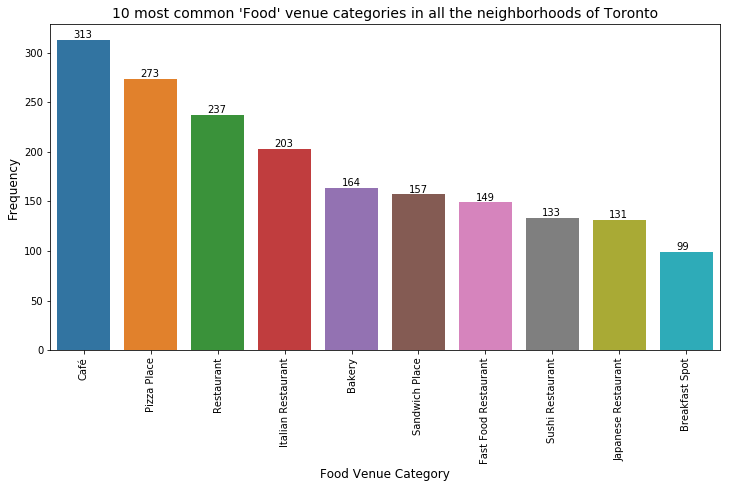

In [31]:
fig = plt.figure(figsize=(12,6))
ax=sns.barplot(y="Frequency", x="Food Venue Category", data=toronto_venues_food_vc.head(10))
plt.title("10 most common 'Food' venue categories in all the neighborhoods of Toronto", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.set_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10})
plt.xlabel("Food Venue Category", fontsize=12)
plt.ylabel ("Frequency", fontsize=12)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+2))
plt.show()

Now let's move on to the **New York City** and find out the most common *Food* Venue Category found there.

In [32]:
# creating a new dataframe for all the New York City Food venue categories using the <code>getNearbyVenues</code> funtion
newyork_venues_food = getNearbyVenues(names=df_newyork_neighborhoods['Neighborhood'],
                                 latitudes=df_newyork_neighborhoods['Latitude'],
                                 longitudes=df_newyork_neighborhoods['Longitude'],
                                 categoryId='4d4b7105d754a06374d81259' # categoryId of 'Food'
                                )

Let's check the size of the resulting New York City dataframe.

In [33]:
print(newyork_venues_food.shape)
newyork_venues_food.head()

(17964, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint
4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant


Let's find out how many unique categories can be curated from all the returned venues.

In [34]:
print('There are {} unique food venue categories.'.format(len(newyork_venues_food['Venue Category'].unique())))

There are 141 unique food venue categories.


In [35]:
"Now let's find out what are the most common {} Food venue categories in New York City.".format(len(newyork_venues_food['Venue Category'].unique()))

"Now let's find out what are the most common 141 Food venue categories in New York City."

Let's create a dataframe for frquency of New York City venues by neighborhood and Food venue category

In [36]:
newyork_venues_food_freq_by_neighborhood_and_food_vc = newyork_venues_food.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Frequency")
newyork_venues_food_freq_by_neighborhood_and_food_vc.head()

,Neighborhood,Venue Category,Frequency
0,Allerton,American Restaurant,3
1,Allerton,Bakery,3
2,Allerton,Breakfast Spot,1
3,Allerton,Caribbean Restaurant,4
4,Allerton,Chinese Restaurant,7


Let's create a dataframe for frquency of New York City Food venues by neighborhood

In [37]:
newyork_venues_food_freq_by_neighborhood = newyork_venues_food.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Food Venue Frequency')
newyork_venues_food_freq_by_neighborhood.head()

,Neighborhood,Food Venue Frequency
0,Allerton,61
1,Annadale,16
2,Arden Heights,11
3,Arlington,12
4,Arrochar,17


In [38]:
newyork_venues_food_vc = newyork_venues_food['Venue Category'].value_counts().to_frame(name='Frequency').reset_index()
newyork_venues_food_vc = newyork_venues_food_vc.rename(columns = {"index": "Food Venue Category"}) 
newyork_venues_food_vc.head()

,Food Venue Category,Frequency
0,Pizza Place,1789
1,Deli / Bodega,1426
2,Chinese Restaurant,1156
3,Italian Restaurant,935
4,Bakery,733


We could see that the most common *Food* venue category found in the neighborhoods of New York City is **Pizza** places. 
**Deli / Bodega**  comes next, and then come the **Chinese** restaurants. 
**Chinese** restaurants closely beat the **Italian** restaurants. 

Now let's create a simple bar plot of the top 10 most common 'Food' venue categories  in *New York City*.

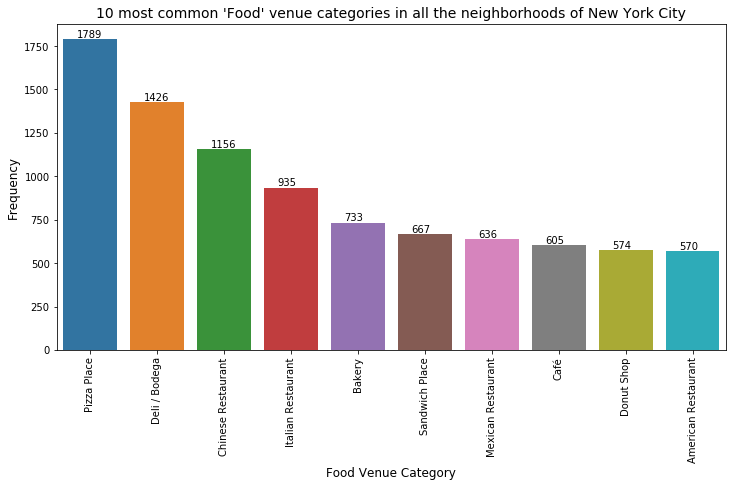

In [39]:
fig = plt.figure(figsize=(12,6))
ax=sns.barplot(y="Frequency", x="Food Venue Category", data=newyork_venues_food_vc.head(10))
plt.title("10 most common 'Food' venue categories in all the neighborhoods of New York City", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.set_context(rc={'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.xlabel("Food Venue Category", fontsize=12)
plt.ylabel ("Frequency", fontsize=12)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+10))
plt.show()

Now let's analyse each neighborhood of **Toronto** for *Food* Venue Category and find the out the most common ones in each neighborhood. 
Later, we'll repeat the same exercise for New York City.

In [40]:
# one hot encoding
toronto_onehot_food = pd.get_dummies(toronto_venues_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_food['Neighborhood'] = toronto_venues_food['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot_food.columns[-1]] + list(toronto_onehot_food.columns[:-1])
toronto_onehot_food = toronto_onehot_food[fixed_columns]
print(toronto_onehot_food.shape)

toronto_onehot_food.head()

(3772, 110)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Pide Place,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Food* Value category

In [41]:
toronto_grouped_food = toronto_onehot_food.groupby('Neighborhood').mean().reset_index()
toronto_grouped_food.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Pide Place,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.0,0.040000,0.0,0.0,0.020000,0.000000,0.0,0.030000,0.0,0.0,0.01,0.040000,0.0,0.03,0.02,0.0,0.1,0.0,0.000000,0.000000,0.000000,0.0,0.01,0.0,0.01,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.0,0.02,0.01,0.01,0.010000,0.04,0.0,0.01,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.06,0.070000,0.0,0.000000,0.01,0.0,0.000000,0.010000,0.0,0.0,0.01,0.0,0.01,0.010000,0.0,0.0,0.0,0.0,0.0,0.050000,0.01,0.0,0.0,0.01,0.080000,0.02,0.000000,0.030000,0.000000,0.0,0.01,0.0,0.0,0.01,0.0,0.000000,0.04,0.030000,0.01,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.020000,0.000000,0.0
1,Agincourt,0.0,0.0,0.025641,0.0,0.0,0.051282,0.025641,0.0,0.051282,0.0,0.0,0.00,0.025641,0.0,0.00,0.00,0.0,0.0,0.0,0.025641,0.051282,0.307692,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.0,0.025641,0.025641,0.0,0.0,0.00,0.0,0.00,0.025641,0.0,0.0,0.0,0.0,0.0,0.051282,0.00,0.0,0.0,0.00,0.051282,0.00,0.051282,0.025641,0.025641,0.0,0.00,0.0,0.0,0.00,0.0,0.025641,0.00,0.025641,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.083333,0.0,0.083333,0.0,0.0,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.041667,0.333333,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.00,0.00,0.00,0.041667,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.083333,0.00,0.0,0.041667,0.000000,0.0,0.0,0.00,0.0,0.00,0.083333,0.0,0.0,0.0,0.0,0.0,0.083333,0.00,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.041667,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.00,0

Now let's create a pandas dataframe to display the top 10 food venues for each neighborhood.

But first, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 food venues for each neighborhood.

In [43]:
num_top_food_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_food_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_food_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_food_venues_sorted['Neighborhood'] = toronto_grouped_food['Neighborhood']

for ind in np.arange(toronto_grouped_food.shape[0]):
    toronto_neighborhoods_food_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_food.iloc[ind, :], num_top_food_venues)

toronto_neighborhoods_food_venues_sorted.head()

,Neighborhood,1st Most Common Food Venue,2nd Most Common Food Venue,3rd Most Common Food Venue,4th Most Common Food Venue,5th Most Common Food Venue,6th Most Common Food Venue,7th Most Common Food Venue,8th Most Common Food Venue,9th Most Common Food Venue,10th Most Common Food Venue
0,"Adelaide, King, Richmond",Café,Restaurant,Japanese Restaurant,Italian Restaurant,Pizza Place,Gastropub,Steakhouse,American Restaurant,Breakfast Spot,Seafood Restaurant
1,Agincourt,Chinese Restaurant,Caribbean Restaurant,Restaurant,Sandwich Place,Asian Restaurant,Pizza Place,Bakery,Cantonese Restaurant,Seafood Restaurant,Shanghai Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Korean Restaurant,Noodle House,Bakery,BBQ Joint,Pizza Place,Fast Food Restaurant,Malay Restaurant,Fried Chicken Joint,Vegetarian / Vegan Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Sandwich Place,Fried Chicken Joint,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant,Donut Shop,Doner Restaurant,Falafel Restaurant,Diner
4,"Alderwood, Long Branch",Pizza Place,Donut Shop,Sandwich Place,Moroccan Restaurant,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant


In [44]:
print('The shape of toronto_neighborhoods_food_venues_sorted is', toronto_neighborhoods_food_venues_sorted.shape)

The shape of toronto_neighborhoods_food_venues_sorted is (102, 11)


Now let's draw a plot for the *1st Most Common Food Venue in the neighborhoods of Toronto*.

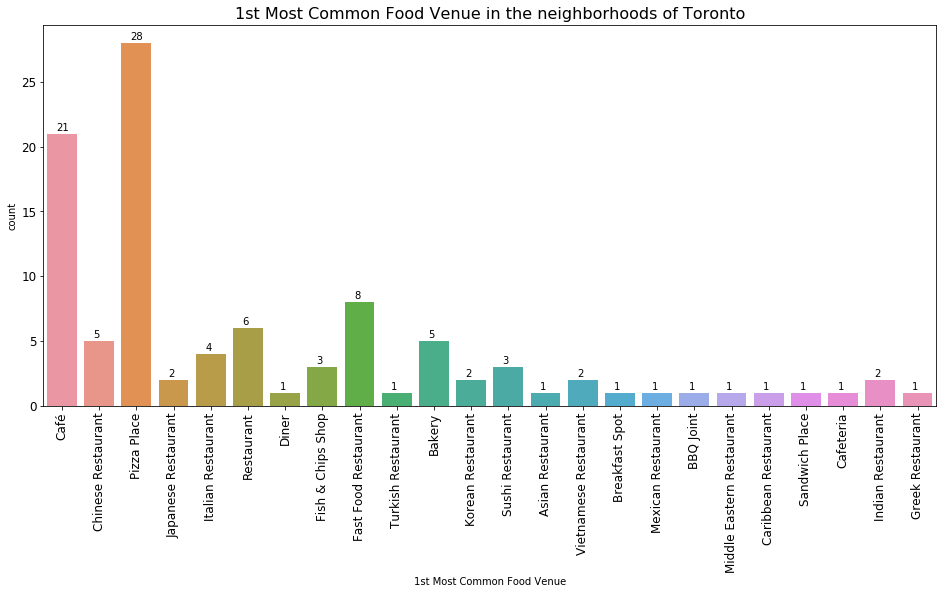

In [45]:
fig = plt.figure(figsize = (16, 7))
ax = sns.countplot(x = '1st Most Common Food Venue', data = toronto_neighborhoods_food_venues_sorted)
ax.set_title('1st Most Common Food Venue in the neighborhoods of Toronto', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+.25))

plt.show()

Just like we analysed each neighborhood of *Toronto* for *Food* Venue Category and found out the out the most common ones in each neighborhood. 
Let's do the same analysis for **New York City** now.

In [46]:
# one hot encoding
newyork_onehot_food = pd.get_dummies(newyork_venues_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot_food['Neighborhood'] = newyork_venues_food['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [newyork_onehot_food.columns[-1]] + list(newyork_onehot_food.columns[:-1])
newyork_onehot_food = newyork_onehot_food[fixed_columns]
print(newyork_onehot_food.shape)

newyork_onehot_food.head()

(17964, 142)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Chaat Place,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Food* Value category

In [47]:
newyork_grouped_food = newyork_onehot_food.groupby('Neighborhood').mean().reset_index()
newyork_grouped_food.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Chaat Place,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Kofte Place,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allerton,0.0,0.0,0.049180,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.04918,0.0,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065574,0.0,0.0,0.0,0.114754,0.0,0.0,0.0,0.0,0.0,0.147541,0.0,0.016393,0.049180,0.0,0.016393,0.0,0.0,0.0,0.0,0.0,0.049180,0.0,0.0,0.0,0.049180,0.0,0.0,0.000000,0.0,0.081967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.081967,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098361,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.049180,0.0,0.016393,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.016393,0.0,0.032787,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Annadale,0.0,0.0,0.187500,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.12500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.062500,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.062500,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312500,0.0,0.000000,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000

Now let's create a pandas dataframe to display the top 10 food venues for each neighborhood.

But first, let's write a function to sort the venues in descending order.

In [48]:
num_top_food_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_food_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_food_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_food_venues_sorted['Neighborhood'] = newyork_grouped_food['Neighborhood']

for ind in np.arange(newyork_grouped_food.shape[0]):
    newyork_neighborhoods_food_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped_food.iloc[ind, :], num_top_food_venues)

newyork_neighborhoods_food_venues_sorted.head()

,Neighborhood,1st Most Common Food Venue,2nd Most Common Food Venue,3rd Most Common Food Venue,4th Most Common Food Venue,5th Most Common Food Venue,6th Most Common Food Venue,7th Most Common Food Venue,8th Most Common Food Venue,9th Most Common Food Venue,10th Most Common Food Venue
0,Allerton,Deli / Bodega,Chinese Restaurant,Pizza Place,Mexican Restaurant,Fried Chicken Joint,Caribbean Restaurant,American Restaurant,Sandwich Place,Fast Food Restaurant,Bakery
1,Annadale,Pizza Place,American Restaurant,Bakery,Restaurant,Deli / Bodega,Food,Sushi Restaurant,Diner,Himalayan Restaurant,Donut Shop
2,Arden Heights,Mexican Restaurant,Food,Bagel Shop,Italian Restaurant,Deli / Bodega,Sushi Restaurant,Pizza Place,Sandwich Place,Chinese Restaurant,Falafel Restaurant
3,Arlington,Deli / Bodega,Fast Food Restaurant,Asian Restaurant,Donut Shop,Snack Place,Spanish Restaurant,Wings Joint,American Restaurant,Hot Dog Joint,Fondue Restaurant
4,Arrochar,Deli / Bodega,Bagel Shop,Italian Restaurant,Pizza Place,Food Truck,Polish Restaurant,Sandwich Place,Middle Eastern Restaurant,Mediterranean Restaurant,Taco Place


In [49]:
print('The shape of newyork_neighborhoods_food_venues_sorted is', newyork_neighborhoods_food_venues_sorted.shape)

The shape of newyork_neighborhoods_food_venues_sorted is (302, 11)


Now let's draw a plot for the *1st Most Common Food Venue in the neighborhoods of New York City*.

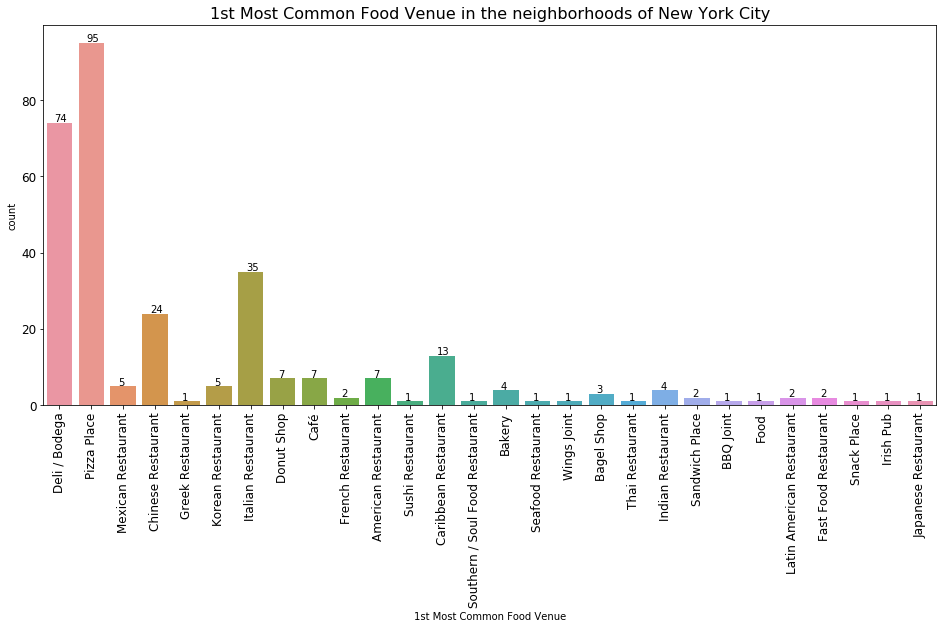

In [50]:
fig = plt.figure(figsize = (16, 7))
ax = sns.countplot(x = '1st Most Common Food Venue', data = newyork_neighborhoods_food_venues_sorted)
ax.set_title('1st Most Common Food Venue in the neighborhoods of New York City', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+.25))

plt.show()

#### 2.2 Most Common *Arts & Entertainment* Venue Category in Toronto and New York City

Next, we'll explore the **Toronto** for its *Arts & Entertainment* venue categories. We'll then repeat the same analysis for New York City. 

In [94]:
# creating a new dataframe for all the Toronto Arts & Entertainment venue categories using the <code>getNearbyVenues</code> funtion
toronto_venues_ae = getNearbyVenues(names=df_postalcodes_toronto['Neighborhood'],
                                 latitudes=df_postalcodes_toronto['Latitude'],
                                 longitudes=df_postalcodes_toronto['Longitude'],
                                 categoryId='4d4b7104d754a06370d81259' # categoryId of 'Arts & Entertainment'
                                )

In [95]:
print(toronto_venues_ae.shape)
toronto_venues_ae.head()

(1035, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Mrs. Claus' Sweatshop,43.753800,-79.319582,Public Art
1,Victoria Village,43.725882,-79.315572,876 411,43.728933,-79.321074,Music Venue
2,Victoria Village,43.725882,-79.315572,Frolick in the Face of Certain Death,43.721814,-79.311157,Theater
3,Victoria Village,43.725882,-79.315572,Sandra Ainsley Gallery,43.719044,-79.308892,Art Gallery
4,"Harbourfront, Regent Park",43.654260,-79.360636,Young Centre for the Performing Arts,43.650825,-79.357593,Performing Arts Venue


In [99]:
print('There are {} unique Arts & Entertainment venue categories.'.format(len(toronto_venues_ae['Venue Category'].unique())))

There are 30 unique Arts & Entertainment venue categories.


In [100]:
"Now let's find out what are the most common {} Arts & Entertainment venue categories in Toronto.".format(len(toronto_venues_ae['Venue Category'].unique()))

"Now let's find out what are the most common 30 Arts & Entertainment venue categories in Toronto."

Let's create a dataframe for frquency of Toronto venues by neighborhood and Arts & Entertainment venue category.

In [101]:
toronto_venues_ae_freq_by_neighborhood_and_ae_vc = toronto_venues_ae.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Frequency")
toronto_venues_ae_freq_by_neighborhood_and_ae_vc.head()

,Neighborhood,Venue Category,Frequency
0,"Adelaide, King, Richmond",Art Gallery,18
1,"Adelaide, King, Richmond",Art Museum,1
2,"Adelaide, King, Richmond",Comedy Club,2
3,"Adelaide, King, Richmond",Concert Hall,6
4,"Adelaide, King, Richmond",Dance Studio,2


Let's create a dataframe for frquency of Toronto Arts & Entertainment venues by neighborhood.

In [102]:
toronto_venues_ae_freq_by_neighborhood = toronto_venues_ae.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Arts & Entertainment Venue Frequency')
toronto_venues_ae_freq_by_neighborhood.head()

,Neighborhood,Arts & Entertainment Venue Frequency
0,"Adelaide, King, Richmond",74
1,Agincourt,1
2,"Agincourt North, L'Amoreaux East, Milliken, St...",1
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",6
4,"Alderwood, Long Branch",5


Let's find out the frequency of Arts & Entertainment Venue Categories in the neighborhoods of Toronoto.

In [103]:
toronto_venues_ae_vc = toronto_venues_ae['Venue Category'].value_counts().to_frame(name='Frequency').reset_index()
toronto_venues_ae_vc = toronto_venues_ae_vc.rename(columns = {"index": "Arts & Entertainment Venue Category"}) 
toronto_venues_ae_vc.head()

,Arts & Entertainment Venue Category,Frequency
0,Art Gallery,210
1,Music Venue,143
2,Movie Theater,136
3,Theater,130
4,Dance Studio,101


Now let's plot the 10 most common 'Arts & Entertainment' venue categories in all the neighborhoods of Toronto.

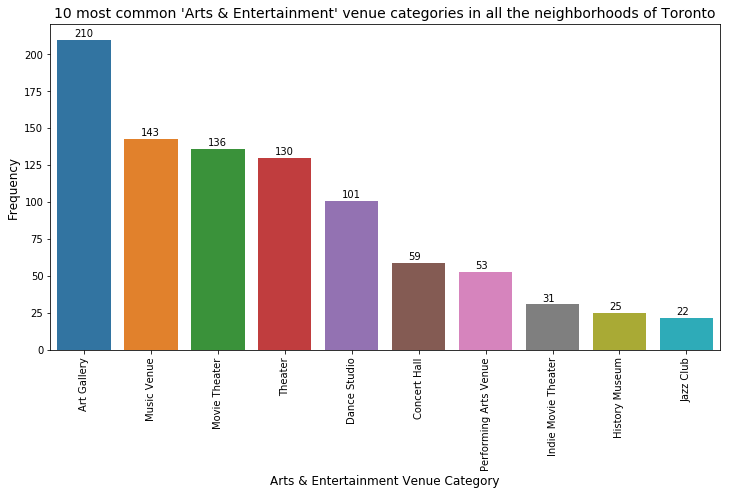

In [104]:
fig = plt.figure(figsize=(12,6))
ax=sns.barplot(y="Frequency", x="Arts & Entertainment Venue Category", data=toronto_venues_ae_vc.head(10))
plt.title("10 most common 'Arts & Entertainment' venue categories in all the neighborhoods of Toronto", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.set_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10})
plt.xlabel("Arts & Entertainment Venue Category", fontsize=12)
plt.ylabel ("Frequency", fontsize=12)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+2))
plt.show()

Now, let's do the same analysis of 'Arts & Entertainment' Venue Category for **New York City**.

In [84]:
# creating a new dataframe for all the New York City Arts & Entertainment venue categories using the <code>getNearbyVenues</code> funtion
newyork_venues_ae = getNearbyVenues(names=df_newyork_neighborhoods['Neighborhood'],
                                 latitudes=df_newyork_neighborhoods['Latitude'],
                                 longitudes=df_newyork_neighborhoods['Longitude'],
                                 categoryId='4d4b7104d754a06370d81259' # categoryId of 'Arts & Entertainment'
                                )

In [106]:
print(newyork_venues_ae.shape)
newyork_venues_ae.head()

(4965, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Grene Diamonds Inc,40.894507,-73.845235,Salsa Club
1,Wakefield,40.894705,-73.847201,The Upper Room,40.892567,-73.846406,Music Venue
2,Wakefield,40.894705,-73.847201,Dyme Life Radio,40.894541,-73.843266,Music Venue
3,Wakefield,40.894705,-73.847201,Major League Music Group,40.891367,-73.850088,Music Venue
4,Wakefield,40.894705,-73.847201,Par-City,40.890211,-73.847002,Music Venue


In [107]:
print('There are {} unique Arts & Entertainment venue categories.'.format(len(newyork_venues_ae['Venue Category'].unique())))

There are 37 unique Arts & Entertainment venue categories.


In [108]:
"Now let's find out what are the most common {} Arts & Entertainment venue categories in New York City.".format(len(newyork_venues_ae['Venue Category'].unique()))

"Now let's find out what are the most common 37 Arts & Entertainment venue categories in New York City."

Let's create a dataframe for frquency of New York City venues by neighborhood and Arts & Entertainment venue category.

In [109]:
newyork_venues_ae_freq_by_neighborhood_and_ae_vc = newyork_venues_ae.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Frequency")
newyork_venues_ae_freq_by_neighborhood_and_ae_vc.head()

,Neighborhood,Venue Category,Frequency
0,Allerton,Country Dance Club,1
1,Allerton,Dance Studio,2
2,Allerton,Music Venue,1
3,Annadale,Dance Studio,1
4,Arden Heights,Art Gallery,1


Let's create a dataframe for frquency of New York City Arts & Entertainment venues by neighborhood.

In [110]:
newyork_venues_ae_freq_by_neighborhood = newyork_venues_ae.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Arts & Entertainment Venue Frequency')
newyork_venues_ae_freq_by_neighborhood.head()

,Neighborhood,Arts & Entertainment Venue Frequency
0,Allerton,4
1,Annadale,1
2,Arden Heights,1
3,Arrochar,2
4,Astoria,12


Let's find out the frequency of Arts & Entertainment Venue Categories in the neighborhoods of New York City.

In [111]:
newyork_venues_ae_vc = newyork_venues_ae['Venue Category'].value_counts().to_frame(name='Frequency').reset_index()
newyork_venues_ae_vc = newyork_venues_ae_vc.rename(columns = {"index": "Arts & Entertainment Venue Category"}) 
newyork_venues_ae_vc.head()

,Arts & Entertainment Venue Category,Frequency
0,Art Gallery,1403
1,Dance Studio,607
2,Theater,549
3,Music Venue,518
4,Performing Arts Venue,249


Now let's plot the 10 most common 'Arts & Entertainment' venue categories in all the neighborhoods of New York City.

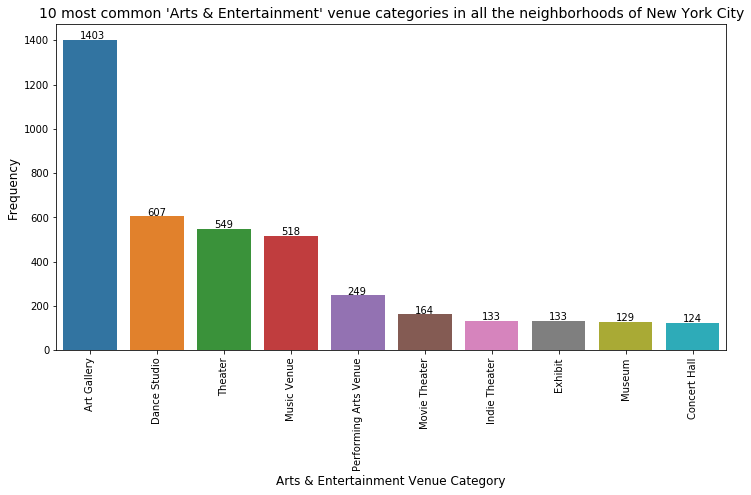

In [112]:
fig = plt.figure(figsize=(12,6))
ax=sns.barplot(y="Frequency", x="Arts & Entertainment Venue Category", data=newyork_venues_ae_vc.head(10))
plt.title("10 most common 'Arts & Entertainment' venue categories in all the neighborhoods of New York City", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.set_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10})
plt.xlabel("Arts & Entertainment Venue Category", fontsize=12)
plt.ylabel ("Frequency", fontsize=12)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+2))
plt.show()

Now let's analyse each neighborhood of **Toronto** for Arts & Entertainment Venue Category and find the out the most common ones in each neighborhood. Later, we'll repeat the same exercise for New York City.

In [118]:
# one hot encoding
toronto_onehot_ae = pd.get_dummies(toronto_venues_ae[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_ae['Neighborhood'] = toronto_venues_ae['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot_ae.columns[-1]] + list(toronto_onehot_ae.columns[:-1])
toronto_onehot_ae = toronto_onehot_ae[fixed_columns]
print(toronto_onehot_ae.shape)

toronto_onehot_ae.head()

(1035, 31)


,Neighborhood,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Exhibit,History Museum,Indie Movie Theater,Indie Theater,Jazz Club,Laser Tag,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Public Art,Racecourse,Rock Club,Salsa Club,Street Art,Theater,Tour Provider
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Victoria Village,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Arts & Entertainment* Value category

In [119]:
toronto_grouped_ae = toronto_onehot_ae.groupby('Neighborhood').mean().reset_index()
toronto_grouped_ae.head()

,Neighborhood,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Exhibit,History Museum,Indie Movie Theater,Indie Theater,Jazz Club,Laser Tag,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Public Art,Racecourse,Rock Club,Salsa Club,Street Art,Theater,Tour Provider
0,"Adelaide, King, Richmond",0.0,0.243243,0.013514,0.0,0.0,0.027027,0.081081,0.0,0.027027,0.040541,0.0,0.040541,0.0,0.027027,0.0,0.189189,0.0,0.013514,0.121622,0.013514,0.013514,0.040541,0.0,0.0,0.0,0.0,0.0,0.0,0.108108,0.0
1,Agincourt,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.166667,0.0,0.000000,0.0,0.833333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Alderwood, Long Branch",0.0,0.000000,0.000000,0.0,0.0,0.200000,0.000000,0.0,0.400000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0


Now let's create a pandas dataframe to display the top 10 Arts & Entertainment venues for each neighborhood.

In [120]:
num_top_ae_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_ae_venues):
    try:
        columns.append('{}{} Most Common Arts & Entertainment Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Arts & Entertainment Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_ae_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_ae_venues_sorted['Neighborhood'] = toronto_grouped_ae['Neighborhood']

for ind in np.arange(toronto_grouped_ae.shape[0]):
    toronto_neighborhoods_ae_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_ae.iloc[ind, :], num_top_ae_venues)

toronto_neighborhoods_ae_venues_sorted.head()

,Neighborhood,1st Most Common Arts & Entertainment Venue,2nd Most Common Arts & Entertainment Venue,3rd Most Common Arts & Entertainment Venue,4th Most Common Arts & Entertainment Venue,5th Most Common Arts & Entertainment Venue,6th Most Common Arts & Entertainment Venue,7th Most Common Arts & Entertainment Venue,8th Most Common Arts & Entertainment Venue,9th Most Common Arts & Entertainment Venue,10th Most Common Arts & Entertainment Venue
0,"Adelaide, King, Richmond",Art Gallery,Movie Theater,Music Venue,Theater,Concert Hall,Indie Movie Theater,Performing Arts Venue,Exhibit,Dance Studio,Jazz Club
1,Agincourt,Music Venue,Tour Provider,Jazz Club,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Country Dance Club
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Dance Studio,Tour Provider,Theater,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Country Dance Club
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Movie Theater,Indie Movie Theater,Tour Provider,Jazz Club,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall
4,"Alderwood, Long Branch",Dance Studio,Comedy Club,Performing Arts Venue,Theater,Tour Provider,Jazz Club,Art Gallery,Art Museum,Arts & Entertainment,Circus


In [121]:
print('The shape of toronto_neighborhoods_ae_venues_sorted is', toronto_neighborhoods_ae_venues_sorted.shape)

The shape of toronto_neighborhoods_ae_venues_sorted is (89, 11)


Now let's draw a plot for the *1st Most Common Arts & Entertainment Venue in the neighborhoods of Toronto*.

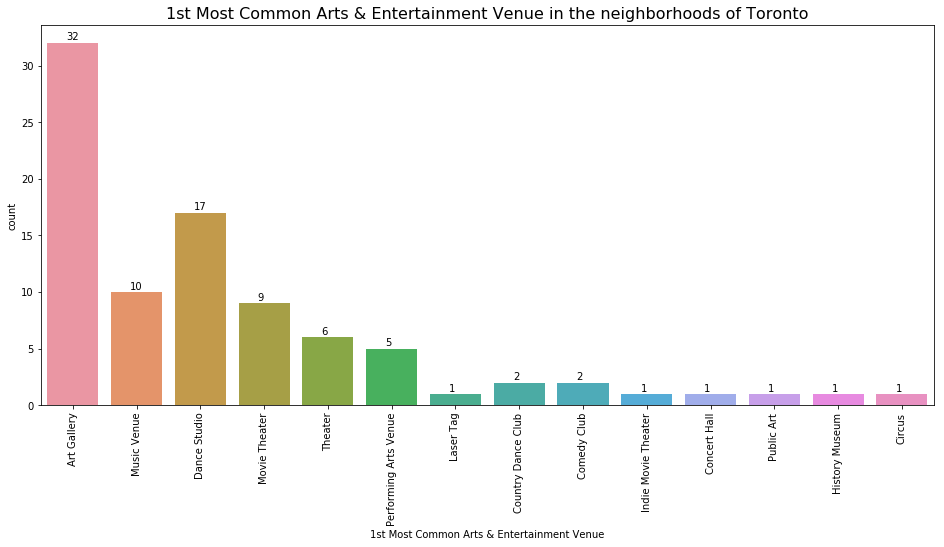

In [123]:
fig = plt.figure(figsize = (16, 7))
ax = sns.countplot(x = '1st Most Common Arts & Entertainment Venue', data = toronto_neighborhoods_ae_venues_sorted)
ax.set_title('1st Most Common Arts & Entertainment Venue in the neighborhoods of Toronto', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+.25))

plt.show()

Just like we analysed each neighborhood of *Toronto* for *Arts & Entertainment* Venue Category and found out the out the most common ones in each neighborhood. 
Let's do the same analysis for **New York City** now.

In [126]:
# one hot encoding
newyork_onehot_ae = pd.get_dummies(newyork_venues_ae[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot_ae['Neighborhood'] = newyork_venues_ae['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [newyork_onehot_ae.columns[-1]] + list(newyork_onehot_ae.columns[:-1])
newyork_onehot_ae = newyork_onehot_ae[fixed_columns]
print(newyork_onehot_ae.shape)

newyork_onehot_ae.head()

(4965, 38)


,Neighborhood,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Erotic Museum,Exhibit,Go Kart Track,History Museum,Indie Movie Theater,Indie Theater,Jazz Club,Laser Tag,Memorial Site,Mini Golf,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Planetarium,Public Art,Rock Club,Roller Rink,Salsa Club,Science Museum,Street Art,Theater,Tour Provider,Zoo Exhibit
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Arts & Entertainment* Value category

In [127]:
newyork_grouped_ae = newyork_onehot_ae.groupby('Neighborhood').mean().reset_index()
newyork_grouped_ae.head()

,Neighborhood,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Erotic Museum,Exhibit,Go Kart Track,History Museum,Indie Movie Theater,Indie Theater,Jazz Club,Laser Tag,Memorial Site,Mini Golf,Movie Theater,Multiplex,Museum,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Planetarium,Public Art,Rock Club,Roller Rink,Salsa Club,Science Museum,Street Art,Theater,Tour Provider,Zoo Exhibit
0,Allerton,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Astoria,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.00,0.416667,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.083333,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let's create a pandas dataframe to display the top 10 Arts & Entertainment venues for each neighborhood.

In [128]:
num_top_ae_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_ae_venues):
    try:
        columns.append('{}{} Most Common Arts & Entertainment Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Arts & Entertainment Venue'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_ae_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_ae_venues_sorted['Neighborhood'] = newyork_grouped_ae['Neighborhood']

for ind in np.arange(newyork_grouped_ae.shape[0]):
    newyork_neighborhoods_ae_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped_ae.iloc[ind, :], num_top_ae_venues)

newyork_neighborhoods_ae_venues_sorted.head()

,Neighborhood,1st Most Common Arts & Entertainment Venue,2nd Most Common Arts & Entertainment Venue,3rd Most Common Arts & Entertainment Venue,4th Most Common Arts & Entertainment Venue,5th Most Common Arts & Entertainment Venue,6th Most Common Arts & Entertainment Venue,7th Most Common Arts & Entertainment Venue,8th Most Common Arts & Entertainment Venue,9th Most Common Arts & Entertainment Venue,10th Most Common Arts & Entertainment Venue
0,Allerton,Dance Studio,Music Venue,Country Dance Club,Erotic Museum,Jazz Club,Indie Theater,Indie Movie Theater,History Museum,Go Kart Track,Exhibit
1,Annadale,Dance Studio,Memorial Site,Jazz Club,Indie Theater,Indie Movie Theater,History Museum,Go Kart Track,Exhibit,Erotic Museum,Zoo Exhibit
2,Arden Heights,Art Gallery,Zoo Exhibit,Erotic Museum,Jazz Club,Indie Theater,Indie Movie Theater,History Museum,Go Kart Track,Exhibit,Dance Studio
3,Arrochar,Dance Studio,Memorial Site,Jazz Club,Indie Theater,Indie Movie Theater,History Museum,Go Kart Track,Exhibit,Erotic Museum,Zoo Exhibit
4,Astoria,Dance Studio,Music Venue,Performing Arts Venue,Art Gallery,Indie Theater,Outdoor Sculpture,Zoo Exhibit,Indie Movie Theater,History Museum,Go Kart Track


In [129]:
print('The shape of newyork_neighborhoods_ae_venues_sorted is', newyork_neighborhoods_ae_venues_sorted.shape)

The shape of newyork_neighborhoods_ae_venues_sorted is (292, 11)


Now let's draw a plot for the *1st Most Common Arts & Entertainment Venue in the neighborhoods of New York City*.

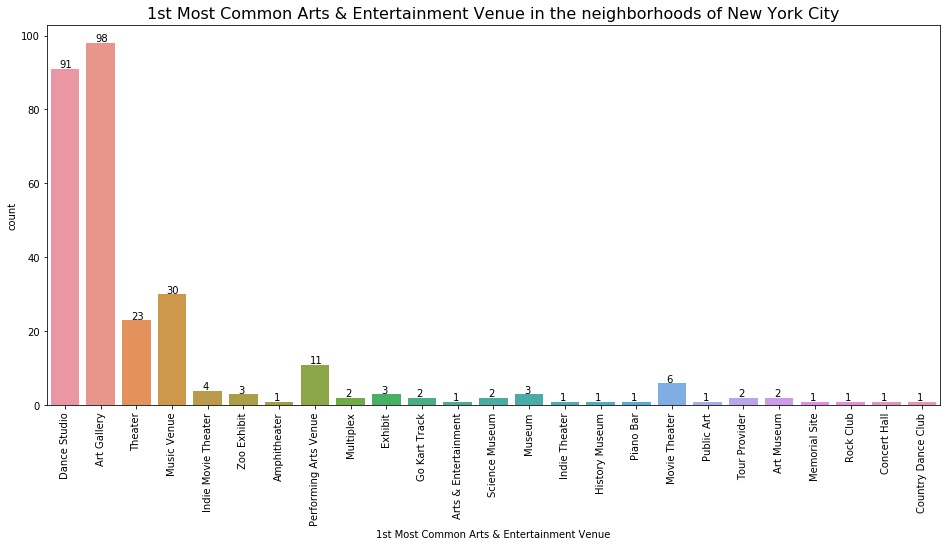

In [130]:
fig = plt.figure(figsize = (16, 7))
ax = sns.countplot(x = '1st Most Common Arts & Entertainment Venue', data = newyork_neighborhoods_ae_venues_sorted)
ax.set_title('1st Most Common Arts & Entertainment Venue in the neighborhoods of New York City', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+.25))

plt.show()